# Минимизация оттока клиентов фитнес-клуба

## Оглавление
* [Цель проекта](#purpose)
* [Исходные данные](#data)
* [Предобработка данных](#preprocessing)
* [Исследовательский анализ данных (EDA)](#eda)
* [Модель прогнозирования оттока клиентов](#model)
* [Кластеризация. Выделение характерных групп посетителей фитнес-клуба](#cluster)
* [Выводы](#conclusions)

## Цель проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Основная задача проекта - выделить характерные группы посетителей клуба и проанализировать, какие факторы больше всего влияют на их отток. Также нужно научиться прогнозировать вероятность оттока в горизонте следующего месяца. Для решения этих задач будем использовать алгоритмы машинного обучения.

## Исходные данные <a id="data"></a>

In [ ]:
#Импортируем нужные библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#читаем данные и выводим информацию о датасете
gym = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets_fitnes/gym_churn.csv')
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [ ]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Исходные данные - набор бинарных и числовых признаков, характеризующих посетителей клуба.

**Бинарные признаки:** пол, территориальная близость спортклуба, участие в акциях (партнерские карты и акция "Приведи друга"), наличие контактного телефона, посещение групповых программ и сам показатель оттока.

**Числовые признаки:** срок клубного контракта (1, 3, 6 или 12 месяцев), возраст, средняя выручка от сопутствующих услуг клуба, срок до окончания контракта, время с момента первого визита в спортклуб, среднее количество посещений в неделю за все время и за последний месяц.


## Предобработка данных <a id="preprocessing"></a>

Для удобства обработки приведем названия столбцов к нижнему регистру.

In [ ]:
gym.columns = [x.lower() for x in gym.columns]

In [ ]:
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверим данные на наличие пропусков, дубликатов и некорректных значений.

Как видно из таблицы выше, пропуски в данных отсутствуют. Проверяем дубликаты:

In [ ]:
print('Количество дублирующихся строк в датасете:', gym.duplicated().sum())

Количество дублирующихся строк в датасете: 0


Проверим, нет ли ошибок в сроках действия контракта:

In [ ]:
print('Количество строк, где срок до окончания действия контракта больше срока действия контракта:', gym.query('month_to_end_contract > contract_period')['churn'].count())

Количество строк, где срок до окончания действия контракта больше срока действия контракта: 0


Данные полны и не содержат явных ошибок. Можно приступать к исследовательскому анализу.

## Исследовательский анализ данных (EDA) <a id="eda"></a>

Посмотрим на средние показатели и на стандартные отклонения по каждому признаку:

In [ ]:
gym.describe().loc[['mean', 'std'],:].T


,mean,std
gender,0.510250,0.499957
near_location,0.845250,0.361711
partner,0.486750,0.499887
promo_friends,0.308500,0.461932
phone,0.903500,0.295313
contract_period,4.681250,4.549706
group_visits,0.412250,0.492301
age,29.184250,3.258367
avg_additional_charges_total,146.943728,96.355602
month_to_end_contract,4.322750,4.191297


В дополнение к цифрам построим визуализацию - распределение значений каждого признака.

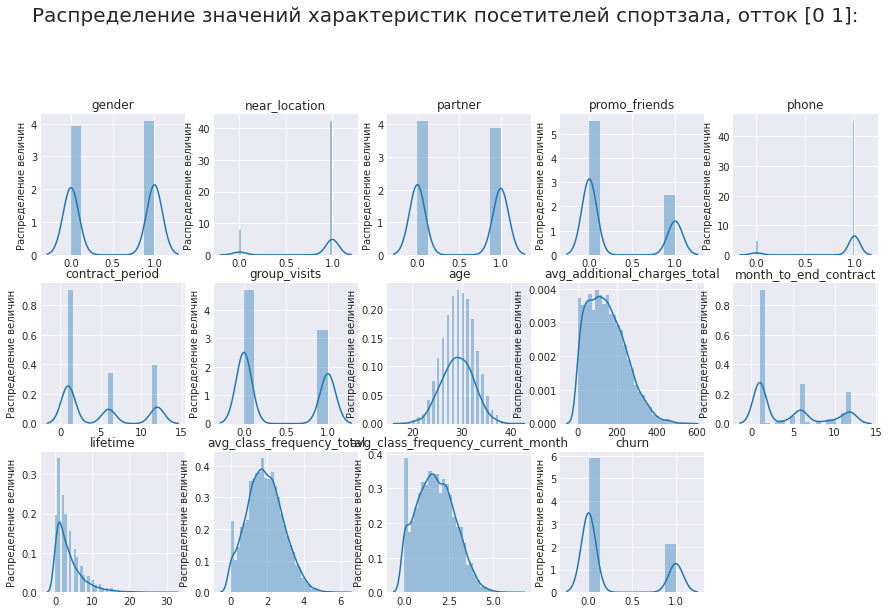

In [ ]:
#Построим функцию выведения серии гистограмм для всех признаков любого датасета
def features_distplot(data):
  with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(15,15))
    plt.suptitle('Распределение значений характеристик посетителей спортзала, отток {}:'.format(data['churn'].unique()), fontsize=20)
    for i, col in enumerate(data.columns):
      num_cols = 3
      num_rows = 4
      sns.distplot(data[col], ax = plt.subplot(5, 5, i + 1))
      plt.title(col)
      plt.xlabel('')
      plt.ylabel('Распределение величин')

features_distplot(gym)

По полученным данным можно сделать выводы:
* Рассматриваемый фитнес-клуб посещают женщины и мужчины практически в равной пропорции
* Большинство посетителей живут или работают в шаговой доступности от спортклуба
* Примерно половина посетителей - члены партнерских программ
* Около 30% пришли по акции "Приведи друга"
* Контактный номер телефона указан в большинстве случаев
* Посетители предпочитают брать абонементы на короткий срок - 1 и 3 месяца. Полгода - самый невостребованный срок контракта
* Групповые тренировки посещает меньше половины членов клуба
* Возраст - величина, которая подчиняется нормальному распределению
* Распределение стоимости дополнительных услуг, которыми пользуются посетители клуба, смещено влево. В среднем сумма таких услуг не превышает 147 у.е. в месяц (с отклонением +- 97 у.е.)
* В среднем до конца контракта у клиентов из этой выборки остается около 4 месяцев
* Распределение времени с момента первого визита в клуб также смещено влево, основная масса посетителей начала это делать меньше полугода назад
* Средняя частота посещения фитнес-клуба за период больше, чем за последний месяц. В большинстве случаев это может служить надежным показателем оттока
* И наконец, сам показатель оттока: около трети клиентов перестали пользоваться услугами фитнеса в рассматриваемый период.



Сравним эти показатели в разрезе лояльных и ушедших клиентов.

In [ ]:
print('Средние показатели признаков по лояльным и ушедшим клиентам:')
gym.groupby('churn').mean()

Средние показатели признаков по лояльным и ушедшим клиентам:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Среди ушедших клиентов в основном те, кто покупал "короткие" абонементы, реже посещал клуб, не ходил на групповые занятия и меньше денег тратил на дополнительные услуги. Похоже, что длительность контракта - очень важный признак, который не позволяет клиенту бросить занятия (с одной стороны, это внушительная стоимость, с другой - выражение серьезности намерений).

От пола и возраста показатель оттока, похоже, зависит слабо, но средний возраст лояльных клиентов чуть выше.

Посмотрим на гистограммы распределения параметров в разрезе оставшихся и ушедших клиентов:

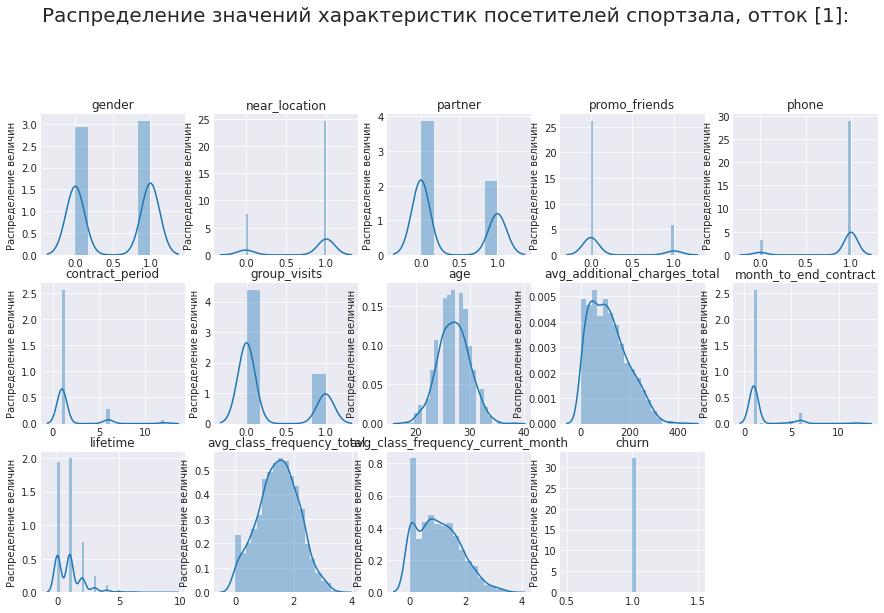

In [ ]:
features_distplot(gym.query('churn == 1'))

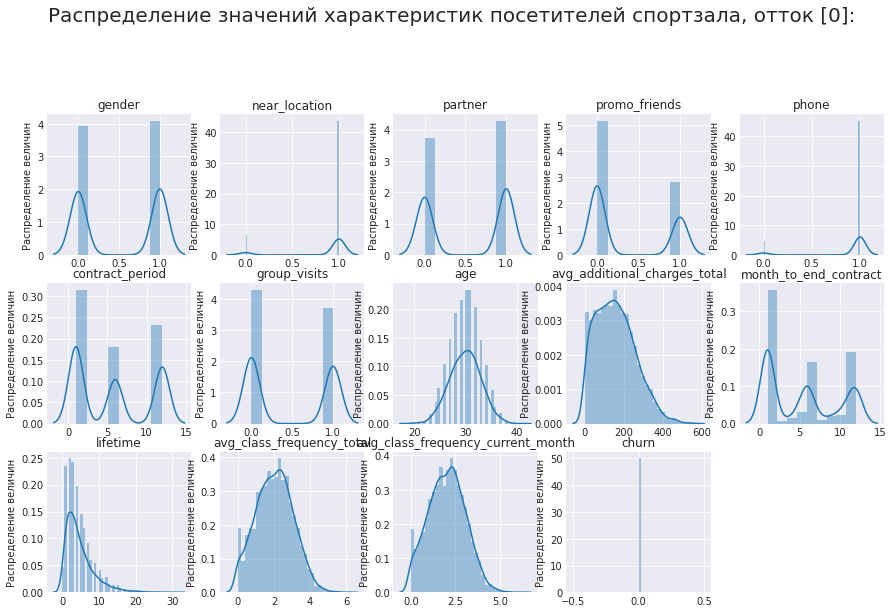

In [ ]:
features_distplot(gym.query('churn == 0'))

Помимо тех моментов, которые были видны по средним, на графиках бросается в глаза то, что ушедшие клиенты практически не посещали спортзал в последний месяц перед окончательным "оттоком". Это основной критерий отбора.

Посмотрим, как коррелируют между собой признаки, собранные в датасете.

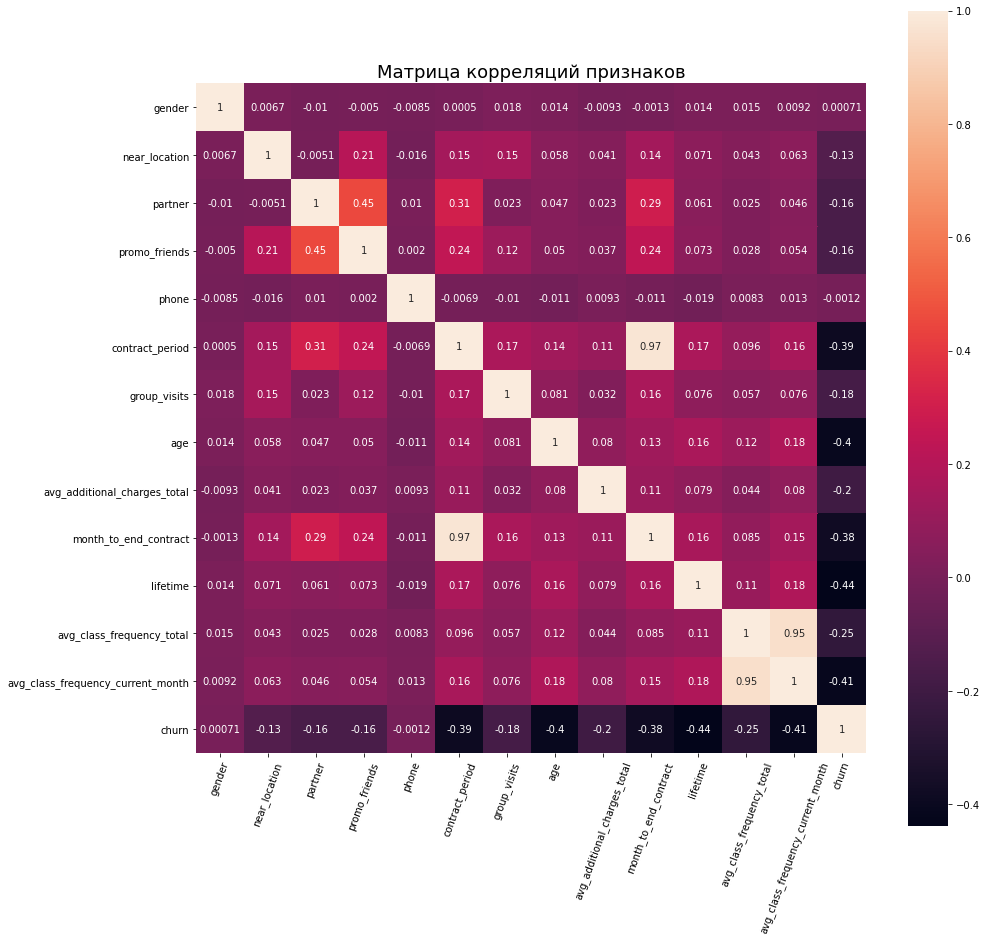

In [ ]:
#Строим матрицу корреляций
corr_gym = gym.corr()
#Строим тепловую карту по этой матрице 
plt.figure(figsize=(15,15))
plt.title('Матрица корреляций признаков', fontdict={'fontsize':18})
sns.heatmap(corr_gym, annot = True, square = True)
plt.xticks(rotation=70)
plt.show()

Матрица корреляций показывает две пары сильно связанных признаков: 
* Длительность контракта и время до окончания контракта (коэффициент корреляции 0,97);
* Частота посещений за весь период и частота посещений в последний месяц (0,95).

Остальные признаки не имеют выраженной связи друг с другом.

Связанные признаки (мультиколлинеарность) могут негативно повлиять на результат обучения модели. Нужно оставить в датасете только по одному признаку из пары.

In [ ]:
#Очищаем датасет от мультиколлинеарных данных
gym_clean = gym.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis = 1)

## Модель прогнозирования оттока клиентов <a id="model"></a>

Построим модель, по которой сможем предсказать отток клиентов в следующем месяце. Поскольку перед нами стоит задача бинарной классификации, при построении модели воспользуемся следующими альтернативными алгоритмами:
* Логистическая регрессия (модель вычисляет вероятность того, что событие принадлежит классу "1" или "0")
* Случайный лес (ансамбль дерева решений, дающий на выходе ту же вероятность)

В имеющейся выборке соотношение лояльных и ушедших клиентов примерно 70:30. Для оценки корректности прогноза нужно использовать метрики, учитывающие этот дисбаланс.

В качестве метрик классификации будем использовать:
* Accuracy (Доля правильных ответов среди всех событий)
* Precision (Доля правильных позитивных ответов из всех правильных)
* Recall (Доля правильных позитивных ответов среди всех позитивных)
* F1 (сводная метрика, учитывающая Precision и Recall)
* ROC-AUC (Эта метрика учитывает несбалансированность наших классов и проверяет, насколько корректно отрабатывает вычисление вероятностей причисления к классам)

Предпочтение при принятии решения о корректности модели нужно отдать метрике Recall (при подсчете оттока важно не упустить ни одного случая, который может потенциально увеличить выручку) и сводным метрикам, в первую очередь ROC-AUC.

In [ ]:

#Разделяем данные на матрицу признаков и целевую переменную
X = gym_clean.drop('churn', axis = 1)
y = gym_clean['churn']

#Делим данные на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#Стандартизируем данные, приводя к нормальному распределению
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)
#Первый алгоритм - логистическая регрессия
models = {LogisticRegression(solver='liblinear', random_state=0) : 'LogisticRegression', DecisionTreeClassifier(random_state=0) : 'DecisionTreeClassifier'}
for model, index in models.items():
    model.fit(X_train_st, y_train)
    probabilities = model.predict_proba(X_test_st)[:, 1]
    predictions = model.predict(X_test_st)
    print('Метрики для модели', index)
  #Доля правильных ответов (TP+TN)/n
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
  #Точность - доля позитивных ответов среди всех правильных (TP/(TP+TN))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
  #Полнота - доля правильных ответов "1" среди всех ответов "1" (TP/(TP+FN))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
  #Сводная метрика полноты и точности
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))


Метрики для модели LogisticRegression
Accuracy: 0.90
Precision: 0.79
Recall: 0.82
F1: 0.81
ROC_AUC: 0.96
Метрики для модели DecisionTreeClassifier
Accuracy: 0.86
Precision: 0.69
Recall: 0.77
F1: 0.73
ROC_AUC: 0.83


Итак, алгоритм логистической регрессии дал более высокие показатели метрик. Посмотрим, какие признаки дают наибольший вес в прогнозе.

In [ ]:
#Строим наиболее удачную из проверенных модель логистической регрессии
m = LogisticRegression(solver='liblinear', random_state=0)
#обучаем на тестовой выборке
m.fit(X_train_st, y_train)
#считаем уверенность принадлежности к классу в валидационной выборке
proba_m = m.predict_proba(X_test_st)[:, 1]
#получаем прогноз на валидационной выборке
pred_m = m.predict(X_test_st)
#сводим в датафрейм признаки и модули их весов (коэффициентов модели)
weights_by_features = pd.DataFrame({'features': X_test.columns, 'weight': abs(m.coef_[0])})
#выводим таблицу, отсортированную по убыванию весов
weights_by_features.sort_values(by = 'weight', ascending = False).head()

,features,weight
9,lifetime,3.805263
5,contract_period,1.313425
10,avg_class_frequency_current_month,1.303555
7,age,1.085719
8,avg_additional_charges_total,0.571378


**Главный признак**, влияющий на вероятность оттока - **время, прошедшее с момента первого посещения спортклуба**. Два следующих практически равнозначны - срок контракта и средняя частота посещения в неделю за последний месяц. 

Поскольку исходные данные имеют дисбаланс классов (распределение значений не 50:50, а 70:30), проверим, как поведет себя прогноз при разном пороге уверенности в присвоении класса:

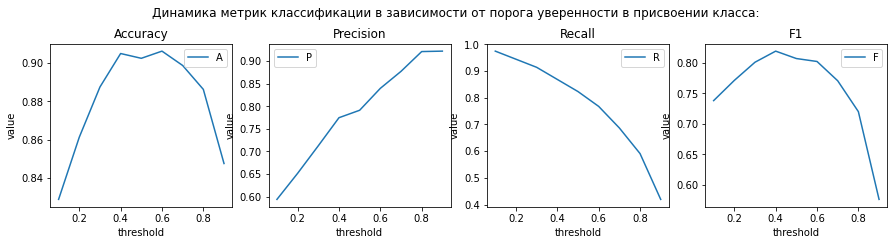

In [ ]:
#задаем порог как список значений от 0,1 до 0,9 с шагом 0.1
threshold = np.linspace(0.1,0.9,9)
#создаем пустой список
results = []
#в цикле добавляем в results значения метрик при всех значениях порога из списка
for t in threshold:
  #прогноз меняется в зависимости от значения порога: если уверенность меньше порога, то прогноз 0, если больше - 1
  custom_predictions = [0 if i < t else 1 for i in proba_m]
  results += [[t, 'Accuracy', accuracy_score(y_test, custom_predictions)]]
  results += [[t, 'Precision', precision_score(y_test, custom_predictions)]]
  results += [[t, 'Recall', recall_score(y_test, custom_predictions)]]
  results += [[t, 'F1', f1_score(y_test, custom_predictions)]]
#преобразуем results в датафрейм
results = pd.DataFrame(results, columns = ['threshold', 'metrics', 'value'])
fig = plt.figure(figsize = (15,3))
#в цикле выводим графики зависимости метрик от заданного порога
for i, metric in enumerate(results['metrics'].unique()):
  plt.suptitle('\n'.join(['Динамика метрик классификации в зависимости от порога уверенности в присвоении класса:']), x = 0.5, y=1.05)
  results.query('metrics == @metric').plot(y = 'value', x = 'threshold', ax = plt.subplot(1, results['metrics'].nunique(), i + 1))
  plt.title(metric)
  plt.xlabel('threshold')
  plt.ylabel('value')
  plt.legend(metric, loc = 'best')


По графикам видно, что баланс метрик достигается при пороге 0,5. Корректировать модель не нужно. 

## Кластеризация. Выделение характерных групп посетителей фитнес-клуба <a id="cluster"></a>

Для выявления характерных посетителей спортклуба применим модель машинного обучения без учителя - агломеративную иерархическую кластеризацию (с визуализацией в  виде дендрограммы).

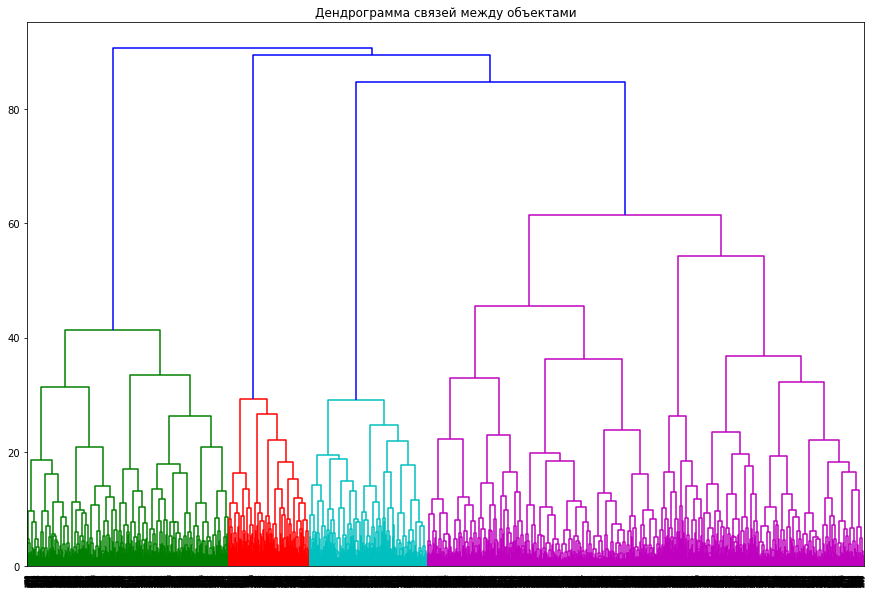

In [ ]:

sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')
#В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма связей между объектами')
plt.show()

Судя по количеству цветов на дендрограмме, оптимальное количество кластеров для нашего датасета - 4. Однако последний кластер довольно велик по сравнению с остальными, поэтому будет рационально разбить его на два. Итого 5 групп.

In [ ]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров
gym_clean['cluster_km'] = labels
gym_clean_grouped = gym_clean.groupby('cluster_km').mean()
gym_clean_grouped

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.490654,1.000000,0.217757,0.070093,1.0,2.042991,0.289720,27.671963,117.183090,1.945794,1.182417,0.558879
1,0.495943,0.995943,0.891481,1.000000,1.0,6.911765,0.523327,29.601420,153.355426,4.281947,1.919083,0.119675
2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
3,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
4,0.546000,0.996000,0.380000,0.011000,1.0,6.209000,0.528000,30.629000,179.000022,5.414000,2.354146,0.017000


Алгоритм выделил группы клиентов по признакам: отсутствие контактных данных, близкое/далёкое расстояние до спортклуба, участие в партнерских и промо-программах.

Посмотрим на распределения признаков по группам.

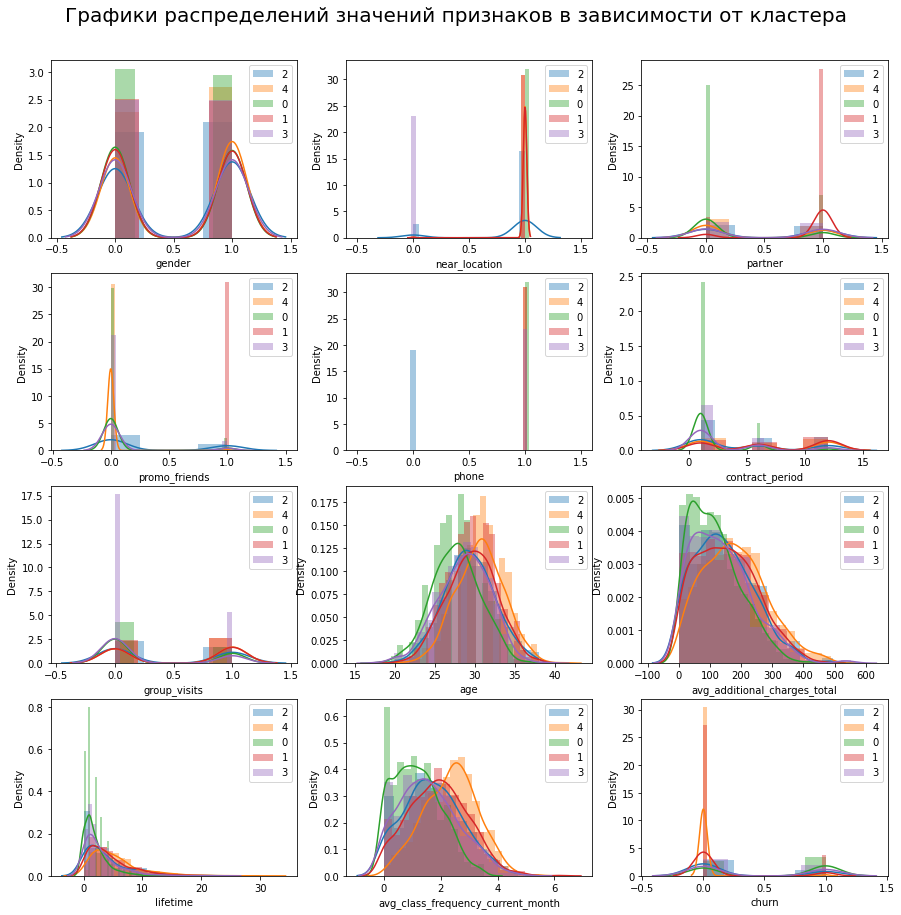

In [ ]:
#список признаков
features = gym_clean.drop('cluster_km', axis = 1).columns
#строим графики в цикле, перебирая уникальные наименования кластеров и признаков в каждом из кластеров
fig = plt.figure(figsize = (15,15))
for cluster in gym_clean['cluster_km'].unique():
    for i, f in enumerate(features):
      plt.suptitle('Графики распределений значений признаков в зависимости от кластера', fontsize = 20, x = 0.5, y= 0.93)
      sns.distplot(gym_clean.query('cluster_km == @cluster')[f], label = cluster, ax = plt.subplot(4,3, i + 1))
      plt.legend()

Взглянем на размер полученных групп:

In [ ]:
cluster_size = gym_clean.groupby('cluster_km')
cluster_size['cluster_km'].count()

cluster_km
0    1070
1     986
2     386
3     558
4    1000
Name: cluster_km, dtype: int64

Итак, распределения показывают:
* **Кластер №0** включает клиентов, пришедших по промо или партнерской программе. Клуб для них удобно расположен, они довольно часто его посещают и тратят там больше денег на дополнительные услуги, чем остальные категории посетителей. Видимо, промо-абонементы подразумевают длинные контракты, в среднем их длительность в этой группе больше полугода. **Показатель оттока** в этой группе также достаточно **низкий** - около 12%. 
* **Кластер №1** выделен по признаку удобства расположения спортклуба. Здесь собраны клиенты, которым долго добираться до фитнеса. Они не ходят на групповые программы и предпочитают короткие контракты. **Доля оттока в этой группе выше среднего** - около 40%
* **Кластер №2** имеет максимальную величину признаков "среднее количество посещений в последний месяц", "длительность контракта" и "возраст". И этот же кластер имеет самый низкий процент ушедших клиентов - 1,7%. **Клиенты этой группы - самые лояльные**
* **Максимальную долю оттока дает кластер №3**. Спортклуб у таких клиентов находится под боком, они редко приходят по акциям или партнерской программе, выбирают короткий срок контракта, редко посещают групповые занятия (как и вообще спортклуб). Возраст клиентов этой группы ниже среднего по датасету
* **Кластер №4** характеризуется в первую очередь отсутствием контактного номера телефона. Прочие характеристики на уровне средних. Отток тоже на среднем уровне - примерно 27%. **Выделение группы по этому признаку оказалось не показательным**



## Выводы <a id="conclusions"></a>

В первой части проекта мы определили **наиболее подходящий алгоритм** для прогнозирования оттока клиентов в будущем периоде - им оказалась **логистическая регрессия**.

Во второй части с помощью дендрограммы и алгоритма кластеризации `K-Means` разделили клиентов спортклуба на 5 условных групп. С каждой из них могут работать маркетологи:

* Кластер №0 - стабильный. Вероятно, дополнительной мотивацией к посещению фитнеса станут скидки на сопутствующие услуги, которыми любят пользоваться посетители этой категории
* Кластер №1 - относительно небольшой по объему. Вряд ли маркетологам стоит ориентироваться на него. Если человеку неудобно посещать клуб, сложно его мотивировать на регулярные занятия
* По кластеру №2 - поощрения для самых лояльных клиентов. Хотя отток в этой группе мал, но сама группа объёмная, и снижение доли ушедших клиентов принесёт дополнительную прибыль
* С кластером №3 нужно вести максимальную работу. Потенциально эти клиенты могут принести наибольший дополнительный доход. Мотивационные письма, акции, скидки, регулярные напоминания, стимулирование к переходу на более долгий контракт - весь арсенал маркетолога в пределах разумного
* По кластеру №4 - выяснить контактные данные, чтобы иметь возможность влиять на частоту посещения мотивирующими предложениями.
